In [25]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
# from class_models import early_stop
# import torch.multiprocessing as mp

In [12]:
# setting device and reproducibility
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print(f"Using device: {device}")

Using device: cuda


## Schedule to find the best dropout regularization drop-off probability
The probability of deactivate neurons in the training task is an important hyperparameter to prevent overfitting. This probability is recommended to be in the range $[0.1-0.5]$.

### Preprocessing 

In [13]:
# import data 
data_frame = pd.read_csv("data/NYCTaxiFares.csv", na_values=["NA", "?"])

In [14]:
# function to calculate the distance of the travel
def haversine_distance(dat_f, lat1, lon1, lat2, lon2):
    
    # average radius of the Earth in (km)
    r = 6371
    
    phi1 = np.radians(dat_f[lat1])
    phi2 = np.radians(dat_f[lat2])
    delta_phi = np.radians(dat_f[lat2] - dat_f[lat1])
    delta_lambda = np.radians(dat_f[lon2] - dat_f[lon1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)
    
    return d

def preprocessing(df_n, cat_cols):
    """
    Preprocesses the data and adds pandas categorical fields to a dataframe.
    :param df_n: pandas dataframe 
    :param cat_cols: list of categorical fields
    :return: pandas dataframe
    """
    # append a 'dist_km' new feature in the dataframe
    df_n['dist_km'] = haversine_distance(df_n, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
    
    # remove outliers
    dfd = df_n[(df_n['fare_amount'] != 49.57) & (df_n['fare_amount'] != 45.00)].copy()
    
    # convert to pd datetime
    dfd['pickup_datetime'] = pd.to_datetime(dfd['pickup_datetime'])
    
    # Correcting pickup_datetime due to daylight savings time (April)
    dfd['EDTdate'] = dfd['pickup_datetime'] - pd.Timedelta(hours=4)
    
    # create new time fields
    dfd['Hour'] = dfd['EDTdate'].dt.hour
    dfd['AMorPM'] = np.where(dfd['Hour']<12, 'am', 'pm')
    dfd['Weekday'] = dfd['EDTdate'].dt.strftime("%a")
    
    # transform to pandas categorical variables
    for cat in cat_cols:
        dfd[cat] = dfd[cat].astype('category')
    
    dfd = dfd.drop(columns=['pickup_datetime'])
    
    return dfd

def model_tensors(df, cat_cols, cont_cols, y_col):
    """
    Get categorical, continuous and label tensors for the model
    :param df: pd dataframe
    :param cat_cols: list of categorical fields
    :param cont_cols: list of continuous fields
    :param y_col: list with the labels
    :return: cats, conts, y tensors
    """
    
    # group the data in categorical continuous and target label    
    cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)
    conts = np.stack([df[col].values for col in cont_cols], axis=1)
    y = df[y_col].values.reshape(-1, 1)

    # Convert to PyTorch tensors
    cats_t = torch.tensor(cats, dtype=torch.int64).to(device)
    conts_t = torch.tensor(conts, dtype=torch.float32).to(device)
    y_t = torch.tensor(y, dtype=torch.float32).to(device)
    
    return cats_t, conts_t, y_t

def create_embedding_sizes(df, cat_cols):
    """
    Create embedding sizes for PyTorch embedding layers
    :param df: pandas dataframe
    :param cat_cols: list of categorical fields
    :return: emb_sizes list
    """
    # categorical sizes list
    cat_sizes = [len(df[col].cat.categories) for col in cat_cols]

    # embedding sizes list (divide the number of unique entries in each column by two, if the result is greater than 50 select 50)
    emb_sizes = [(size, min(50,(size+1)//2)) for size in cat_sizes]
    
    return emb_sizes


In [15]:
df = preprocessing(data_frame, ['Hour', 'AMorPM', 'Weekday'])

cats, conts, y = model_tensors(df, ['Hour', 'AMorPM', 'Weekday'], ['dist_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], ['fare_amount'])

# number of continuous fields of the conts tensor
n_cont = conts.shape[1]

emb_sizes = create_embedding_sizes(df, ['Hour', 'AMorPM', 'Weekday'])

### Model definition

In [32]:
# Define the model
class TabularModel(nn.Module):
    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.batch_norm_cont = nn.BatchNorm1d(n_cont)

        layer_list = []
        n_emb = sum([nf for ni, nf in emb_sizes])
        n_in = n_emb + n_cont
        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i

        layer_list.append(nn.Linear(layers[-1], out_size))
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x_cat, x_cont):
        embeddings = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.batch_norm_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

### Split Function

In [33]:
# Function-generator to split the data into k folds
def kfold_split(k, X_cat, X_cont, y):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X_cat):
        X_cat_train, X_cat_val = X_cat[train_index], X_cat[val_index]
        X_cont_train, X_cont_val = X_cont[train_index], X_cont[val_index]
        y_train, y_val = y[train_index], y[val_index]
        yield X_cat_train, X_cat_val, X_cont_train, X_cont_val, y_train, y_val

### K-Folds configuration

In [34]:
# Experiment with different dropout rates
arch_configs = [
    ([400, 300, 200, 100], 0.5),
    ([400, 300, 200, 100], 0.4),
    ([400, 300, 200, 100], 0.3),
    ([400, 300, 200, 100], 0.2),
    ([400, 300, 200, 100], 0.1),
]

out_size = 1
batch_size = 128
epochs = 150
results_kfold = []
k = 2

In [35]:
for arch, p in arch_configs:
    fold = 0
    
    print(f"Testing architecture: {arch} with dropout: {p}")

    for X_cat_train, X_cat_val, X_cont_train, X_cont_val, y_train, y_val in kfold_split(k, cats, conts, y):
        fold += 1
        print(f"Fold {fold}/{k}")

        # Create datasets and loaders
        train_dataset = TensorDataset(X_cat_train, X_cont_train, y_train)
        val_dataset = TensorDataset(X_cat_val, X_cont_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, loss, optimizer, and scheduler
        model = TabularModel(emb_sizes, n_cont, out_size, arch, p).to(device)
        criterion = nn.SmoothL1Loss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        for epoch in range(epochs):
            model.train()
            train_losses = []

            for X_cat_batch, X_cont_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(X_cat_batch, X_cont_batch)
                loss = torch.sqrt(criterion(y_pred, y_batch))
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = []
            with torch.no_grad():
                for X_cat_batch, X_cont_batch, y_batch in val_loader:
                    y_pred = model(X_cat_batch, X_cont_batch)
                    loss = torch.sqrt(criterion(y_pred, y_batch))
                    val_losses.append(loss.item())

            mean_val_loss = np.mean(val_losses)
            mean_train_loss = np.mean(train_losses)
            
            # evaluates the error over the entire k-fold validation data
            with torch.no_grad():
                r_y_hat = model(X_cat_val, X_cont_val).flatten() 
                r_loss = torch.sqrt(criterion(r_y_hat, y_val.flatten()))
            
            if epoch % 20 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {mean_train_loss:.4f}, Val Loss: {mean_val_loss:.4f}")

            # Save results for the current fold and configuration
            results_kfold.append({
                "Architecture": str(arch),
                "Fold": fold,
                "Epoch": epoch + 1,
                "Dropout Probability": p,
                "Train Loos": mean_train_loss,
                "Validation Loss": mean_val_loss,
                "Total Root SmoothL1 Error": r_loss.item(),
            })

Testing architecture: [400, 300, 200, 100] with dropout: 0.5
Fold 1/2
Epoch 1/150, Train Loss: 2.0241, Val Loss: 1.1060
Epoch 21/150, Train Loss: 1.1356, Val Loss: 0.9739
Epoch 41/150, Train Loss: 1.1017, Val Loss: 0.9486
Epoch 61/150, Train Loss: 1.0894, Val Loss: 0.9398
Epoch 81/150, Train Loss: 1.0680, Val Loss: 0.9490
Epoch 101/150, Train Loss: 1.0662, Val Loss: 0.9427
Epoch 121/150, Train Loss: 1.0579, Val Loss: 0.9453
Epoch 141/150, Train Loss: 1.0579, Val Loss: 0.9459
Fold 2/2
Epoch 1/150, Train Loss: 2.0290, Val Loss: 1.1155
Epoch 21/150, Train Loss: 1.1344, Val Loss: 0.9886
Epoch 41/150, Train Loss: 1.1055, Val Loss: 0.9607
Epoch 61/150, Train Loss: 1.0839, Val Loss: 0.9666
Epoch 81/150, Train Loss: 1.0721, Val Loss: 0.9638
Epoch 101/150, Train Loss: 1.0745, Val Loss: 0.9478
Epoch 121/150, Train Loss: 1.0551, Val Loss: 0.9396
Epoch 141/150, Train Loss: 1.0545, Val Loss: 0.9486
Testing architecture: [400, 300, 200, 100] with dropout: 0.4
Fold 1/2
Epoch 1/150, Train Loss: 1.9617

### Postprocessing 

In [37]:
# convert the results list to pd.dataframe
df_results = pd.DataFrame(results_kfold)
df_results.to_csv("export/results_dropout.csv", index=False)
df_results.head()

,Architecture,Fold,Epoch,Dropout Probability,Train Loos,Validation Loss,Total Root SmoothL1 Error
0,"[400, 300, 200, 100]",1,1,0.5,2.024091,1.105984,1.109872
1,"[400, 300, 200, 100]",1,2,0.5,1.320874,1.073932,1.078065
2,"[400, 300, 200, 100]",1,3,0.5,1.266493,1.079431,1.083556
3,"[400, 300, 200, 100]",1,4,0.5,1.244039,1.070634,1.074912
4,"[400, 300, 200, 100]",1,5,0.5,1.226563,1.052221,1.056442


### Results Statistics

In [38]:
# Group by architecture and dropout probability, and then calculate statistics
stats_summary = df_results.groupby(['Architecture', 'Dropout Probability']).agg(
    Mean_Total_Error=('Total Root SmoothL1 Error', 'mean'),
    Std_Total_Error=('Total Root SmoothL1 Error', 'std'),
    Min_Total_Error=('Total Root SmoothL1 Error', 'min'),
    Max_Total_Error=('Total Root SmoothL1 Error', 'max')
).reset_index()

print(stats_summary)

           Architecture  Dropout Probability  Mean_Total_Error  \
0  [400, 300, 200, 100]                  0.1          0.931114   
1  [400, 300, 200, 100]                  0.2          0.932275   
2  [400, 300, 200, 100]                  0.3          0.942171   
3  [400, 300, 200, 100]                  0.4          0.952195   
4  [400, 300, 200, 100]                  0.5          0.964612   

   Std_Total_Error  Min_Total_Error  Max_Total_Error  
0         0.021172         0.911580         1.105392  
1         0.021521         0.908732         1.082319  
2         0.024902         0.918171         1.096001  
3         0.025451         0.926267         1.090723  
4         0.029989         0.937247         1.118951  


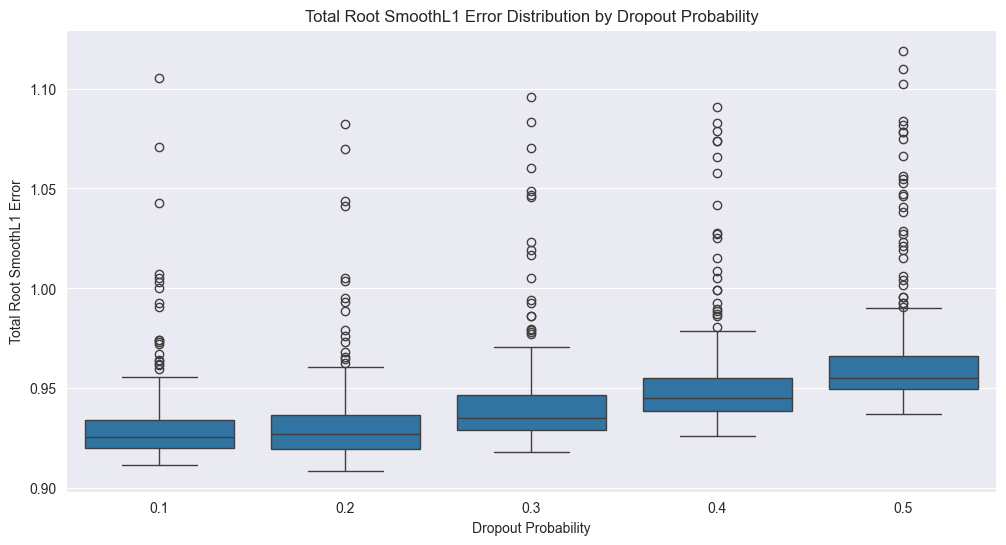

In [39]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dropout Probability', y='Total Root SmoothL1 Error', data=df_results)
plt.title('Total Root SmoothL1 Error Distribution by Dropout Probability')
plt.show()

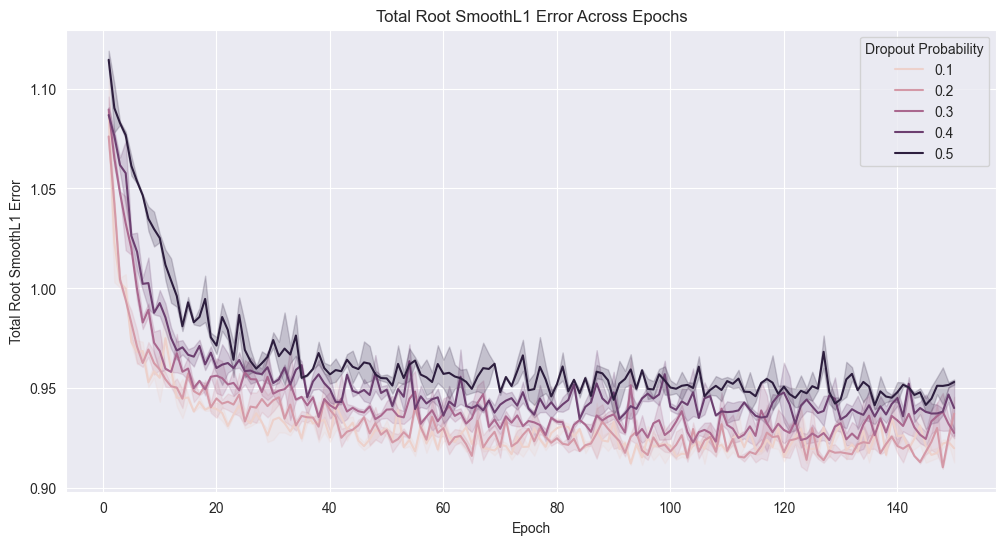

In [40]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Epoch', y='Total Root SmoothL1 Error', hue='Dropout Probability', data=df_results)
plt.title('Total Root SmoothL1 Error Across Epochs')
plt.show()

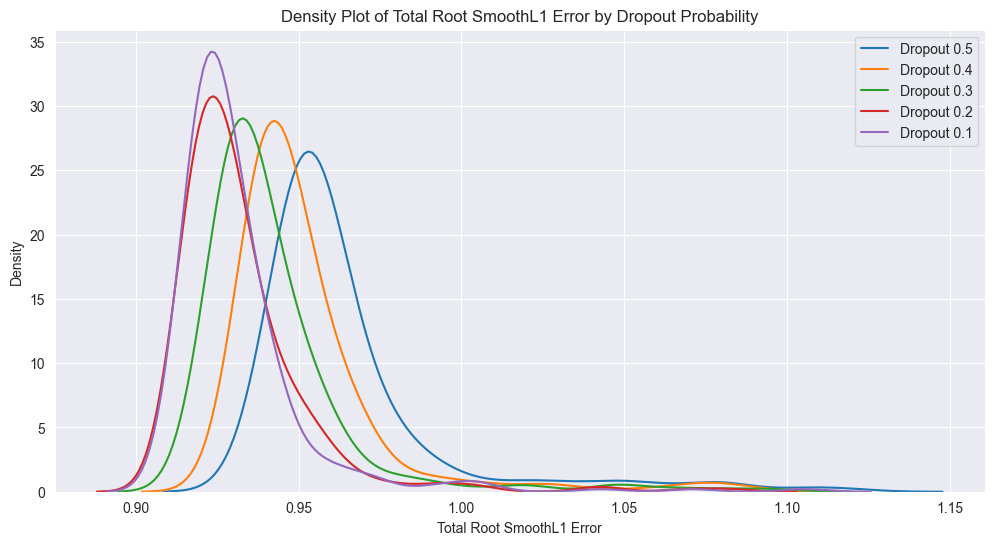

In [41]:
plt.figure(figsize=(12, 6))
for prob in df_results['Dropout Probability'].unique():
    sns.kdeplot(df_results[df_results['Dropout Probability'] == prob]['Total Root SmoothL1 Error'], label=f"Dropout {prob}")

plt.title('Density Plot of Total Root SmoothL1 Error by Dropout Probability')
plt.legend()
plt.show()

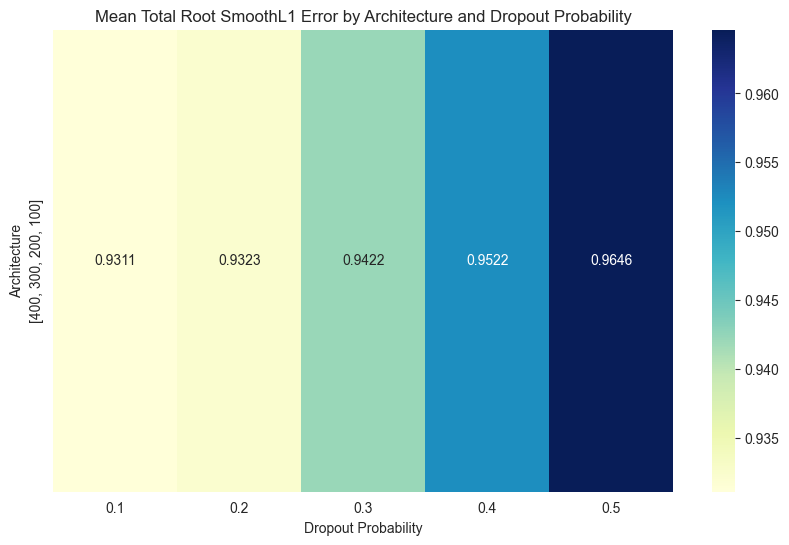

In [42]:
heatmap_data = stats_summary.pivot(index="Architecture", columns="Dropout Probability", values="Mean_Total_Error") # Use keyword arguments for index, columns, and values
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Mean Total Root SmoothL1 Error by Architecture and Dropout Probability')
plt.show()